<a href="https://colab.research.google.com/github/nadiarecilia/UAS_Artificial-Inteligence/blob/main/UAS_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

**SKEMA SEDERHANA UNTUK MENGGABUNGKAN CLUSTERING DENGAN MACHINE LEARNING**


---



# **IMPORT LIBRARY UNTUK PREPROCESSING DATA, CLUSTERING, MODEL, DAN EVALUASI KINERJA MENGGUNAKAN MACHINE LEARNING**


In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

## **TAHAP 1 : PREPROCESSING DATA**

**1. UPLOAD FILE DAN PILIH FILE**


*   Bertujuan untuk mengupload file dari lokal, lalu membaca data tersebut ke dalam format yang lebih mudah diproses menggunakan pandas DataFrame




In [30]:
uploaded = files.upload()

df = pd.read_csv('netflix_titles.csv')

Saving netflix_titles.csv to netflix_titles (4).csv


**2. Bersihkan Data**
*   Menggunakan *fillna()* untuk mengisi nilai yang hilang pada kolom-kolom, seperti *rating*, *duration*, *director*, *cast*, *country*, dan *date_added*

**3. Normalisasi/Transformasi Data**
*   Mengubah format durasi dari string menjadi angka dalam menit
*   Menggunakan MinMaxScaller untuk menormalkan *duration*, dan *release_year* ke rentang [0,1]
*   Mengkonversi rating menjadi kolom-kolom biner menggunakan *pd.get_dummies()

**4. Memilih Fitur Relevan**
*   Menangani kolom yang tidak relevan
*   Menampilkan data setelah preprocessing dan memeriksa apakah masih ada missing values









In [31]:
df['rating'] = df['rating'].fillna('Not Rated')
df['duration'] = df['duration'].fillna('0 min')
df['director'] = df['director'].fillna('Unknown')
df['cast'] = df['cast'].fillna('Unknown')
df['country'] = df['country'].fillna('Unknown')
df['date_added'] = df['date_added'].fillna('Unknown')

def convert_duration(duration):
    if 'min' in duration:
        return int(duration.replace(' min', ''))
    elif 'Season' in duration:
        return int(duration.split(' ')[0]) * 60
    else:
        return 0

df['duration'] = df['duration'].apply(convert_duration)

scaler = MinMaxScaler()
df['duration_scaled'] = scaler.fit_transform(df[['duration']])

df = pd.get_dummies(df, columns=['rating'], drop_first=True)

df['type_TV Show'] = df['type'].apply(lambda x: 1 if x == 'TV Show' else 0)
df['type_Movie'] = df['type'].apply(lambda x: 1 if x == 'Movie' else 0)

scaler_year = MinMaxScaler()
df['release_year_scaled'] = scaler_year.fit_transform(df[['release_year']])

features_to_keep = ['show_id', 'title', 'director', 'cast', 'country', 'date_added', 'duration_scaled', 'release_year_scaled', 'type_TV Show', 'type_Movie'] + list(df.filter(like='rating_').columns)
df_cleaned = df[features_to_keep]

print(df_cleaned.head())

print("Jumlah Missing Values setelah Dibersihkan:")
print(df_cleaned.isnull().sum())

  show_id                  title         director  \
0      s1   Dick Johnson Is Dead  Kirsten Johnson   
1      s2          Blood & Water          Unknown   
2      s3              Ganglands  Julien Leclercq   
3      s4  Jailbirds New Orleans          Unknown   
4      s5           Kota Factory          Unknown   

                                                cast        country  \
0                                            Unknown  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...        Unknown   
3                                            Unknown        Unknown   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

           date_added  duration_scaled  release_year_scaled  type_TV Show  \
0  September 25, 2021         0.088235             0.989583             0   
1  September 24, 2021         0.117647             1.000000             1   
2  September 24, 2021  

# **TAHAP 2 : CLUSTERING**

**1. Memilih Algoritma K-Means Clustering**
*   Data yang sudah dibersihkan dipilih
fitur relevannya yaitu `release_year` dan `duration_scaled`, untuk proses clustering
*   Fitur yang dipilih dinormalisasikan menggunakan `StandarScaler` agar memiliki distribusi dengan rata-rata 0 dan standar deviasi 1, untuk algoritma K-Means.

**2. Menentukan Jumlah Cluster K**
*   Menggunakan Elbow, dengan nilai k (1 - 10), untuk menemukan nilai K optimal berdasarkan grafik pada WCSS (Within-Cluster Sum of Squares).

**3. Menjalankan Algoritma Clustering**
*   Setelah menentukan nilai K=3, K-Means dijalankan untuk mengelompokkan data ke dalam 3 klaster dan hasilnya disimpan pada kolom baru di dataframe

**4. Simpan Hasil Clustering**
*   Hasil clustering divisualisasikan dalam scatter plot, dengan warna klaster yang berbeda
*   Data disimpan dalam file CSV yang telah diproses beserta klaster yang dihasilkan









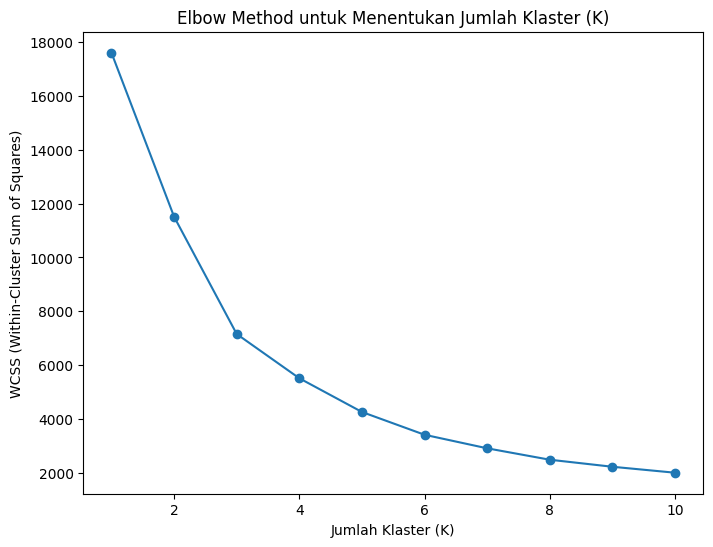

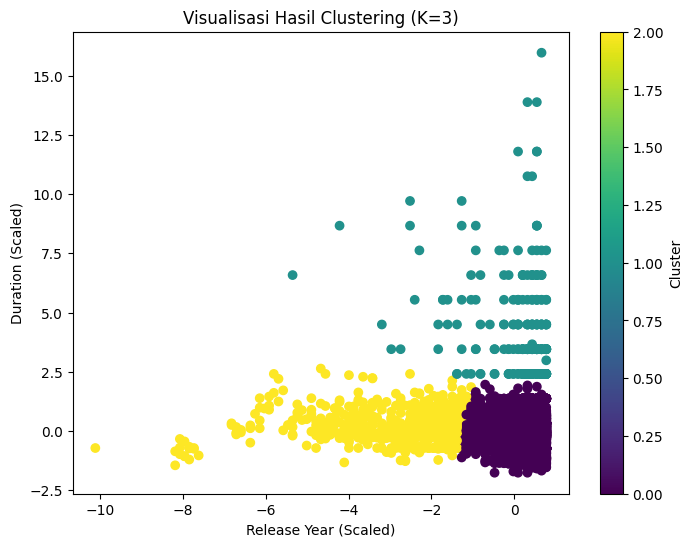

  show_id                  title  cluster
0      s1   Dick Johnson Is Dead        0
1      s2          Blood & Water        0
2      s3              Ganglands        0
3      s4  Jailbirds New Orleans        0
4      s5           Kota Factory        0


In [32]:
features = df[['release_year', 'duration_scaled']]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(features_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method untuk Menentukan Jumlah Klaster (K)')
plt.xlabel('Jumlah Klaster (K)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()

optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=300, n_init=10, random_state=42)
df['cluster'] = kmeans.fit_predict(features_scaled)

df.to_csv('data_with_clusters.csv', index=False)

plt.figure(figsize=(8, 6))
plt.scatter(features_scaled[:, 0], features_scaled[:, 1], c=df['cluster'], cmap='viridis')
plt.title(f'Visualisasi Hasil Clustering (K={optimal_k})')
plt.xlabel('Release Year (Scaled)')
plt.ylabel('Duration (Scaled)')
plt.colorbar(label='Cluster')
plt.show()

print(df[['show_id', 'title', 'cluster']].head())

# **TAHAP 3 : PENGGABUNGAN DENGAN MACHINE LEARNING**

**1. Memilih Model Machine Learning: Klasifikasi Menggunakan Random Forest**
*   Mengecek kolom yang ada di dalam DataFrame menggunakan `df.coloums`
*   Jika tahun rilis genap diberi nilai 'TV-MA' dan jika ganjil diberi nilai 'PG'

**2. Hasil Cluster Sebagai Fitur Tambahan**
*   Hasil clustering K-Means dimasukkan ke dalam cluster sebagai fitur tambahan
*   rating_class ditambahkan, mengklasifikasikan rating menjadi dua kelas: 'High' untuk 'TV-MA' dan 'R', 'Low' untuk rating lainnya, dan 'Unknown' untuk nilai yang tidak ada
*   Memilih fitur (`x`) dan target (`y`) untuk model

**3. Latih Model Machine Learning**
*   Data dibagi menjadi dua pelatihan dan pengujian dengan rasio 80:20 menggunakan `train_test_split`
*   Model Random Forest dilatih menggunakan data pelatihan (`x_train` dan `y_train`)

**4. Evaluasi Kinerja Model**
*   Model dievaluasi dengan memprediksi data pengujian (`x_train`)dan membandingkan hasil prediksi dengan target asli (`y_test`)







In [33]:
print(df.columns)

if 'rating' not in df.columns:
    print("'rating' column is missing, creating a new column...")
    df['rating'] = ['TV-MA' if year % 2 == 0 else 'PG' for year in df['release_year']]

print(df.columns)

df['cluster'] = kmeans.labels_

df['rating_class'] = df['rating'].apply(lambda x: 'High' if x in ['TV-MA', 'R'] else 'Low' if pd.notna(x) else 'Unknown')

X = df[['duration_scaled', 'release_year', 'cluster']]
y = df['rating_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'duration', 'listed_in', 'description',
       'duration_scaled', 'rating_74 min', 'rating_84 min', 'rating_G',
       'rating_NC-17', 'rating_NR', 'rating_Not Rated', 'rating_PG',
       'rating_PG-13', 'rating_R', 'rating_TV-14', 'rating_TV-G',
       'rating_TV-MA', 'rating_TV-PG', 'rating_TV-Y', 'rating_TV-Y7',
       'rating_TV-Y7-FV', 'rating_UR', 'type_TV Show', 'type_Movie',
       'release_year_scaled', 'cluster'],
      dtype='object')
'rating' column is missing, creating a new column...
Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'duration', 'listed_in', 'description',
       'duration_scaled', 'rating_74 min', 'rating_84 min', 'rating_G',
       'rating_NC-17', 'rating_NR', 'rating_Not Rated', 'rating_PG',
       'rating_PG-13', 'rating_R', 'rating_TV-14', 'rating_TV-G',
       'rating_TV-MA', 'rating_TV-PG', 'rati

# **TAHAP 4 : EVALUASI DAN PENGOPTIMALAN**


**1. Evaluasi Kinerja Model**
*   Model yang sudah dilatih dievaluasi menggunakan data uji (`x_test`)
*   Akurasi dihitung menggunakan `accuracy_score`, sementara presisi, recall, dan f1-score dilaporkan menggunakan `classification_report`
*   Confusion Matrix digunakan untuk memvisualisasi hasil prediksi model model dengan bantuan heatmap

**2. Melakukan Pengoptimalan Hyperparameter**
*   `param_grid` untuk Random Forest didefinisikan untuk mencari kombinasi hyperparameter terbaik
*   gridSearchCV digunakan untuk mencari hyperparameter terbaik diuji kembali pada data uji

**3. Bandingkan Hasil dengan Model Tanpa Clustering**
*   Bandingkan model dengan menggunakan hasil clustering (`cluster`) sebagai fitur tambahan dengan model tanpa clustering (hanya `duration_scaled` dan `release_year_scaled`)
*   Evaluasi dilakukan dengan mengukur akurasi, classification report, dan confusion matrix untuk kedua model
*   Jika kurasi dengan clustering lebih tinggi, clustering memberikan kontribusi prositif untuk meningkatkan kinerja model klasifikasi
*   Jika akurasi tanpa clustering lebih tinggi, clustering tidak memberikan peningkatkan yang signifikan dan malah menurunkan kinerja model
*   Berdasarkan hasil akurasi, model dengan clustering memiliki akurasi lebih tinggi dibandingkan tanpa clustering, ini menunjukkan kinerja model dalam hal clustering berhasil meningkatkan kinerja model dalam hal prediksi kelas `rating_class` (High/Low).











Accuracy with clustering:  0.9500567536889898
Classification Report with clustering: 
               precision    recall  f1-score   support

        High       0.95      0.95      0.95       893
         Low       0.95      0.95      0.95       869

    accuracy                           0.95      1762
   macro avg       0.95      0.95      0.95      1762
weighted avg       0.95      0.95      0.95      1762



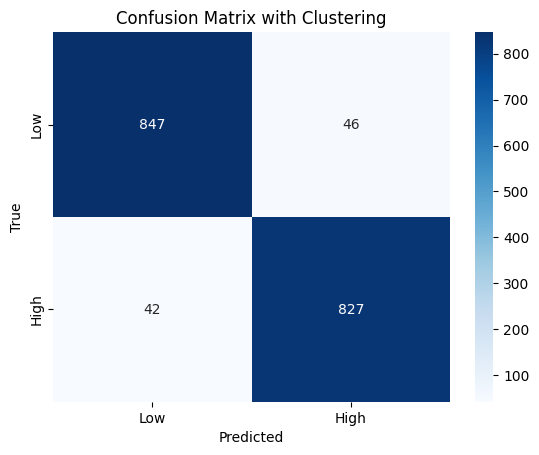

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Hyperparameters:  {'bootstrap': True, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}
Accuracy with optimized hyperparameters:  0.9534619750283768
Classification Report with optimized hyperparameters: 
               precision    recall  f1-score   support

        High       0.95      0.96      0.95       893
         Low       0.96      0.95      0.95       869

    accuracy                           0.95      1762
   macro avg       0.95      0.95      0.95      1762
weighted avg       0.95      0.95      0.95      1762



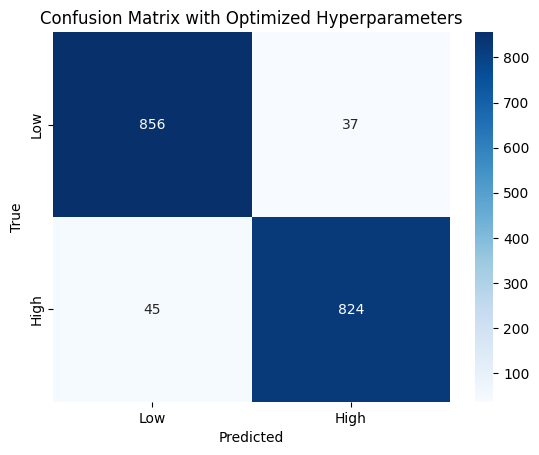

Accuracy without clustering:  0.9387060158910329
Classification Report without clustering: 
               precision    recall  f1-score   support

        High       0.94      0.94      0.94       893
         Low       0.94      0.94      0.94       869

    accuracy                           0.94      1762
   macro avg       0.94      0.94      0.94      1762
weighted avg       0.94      0.94      0.94      1762



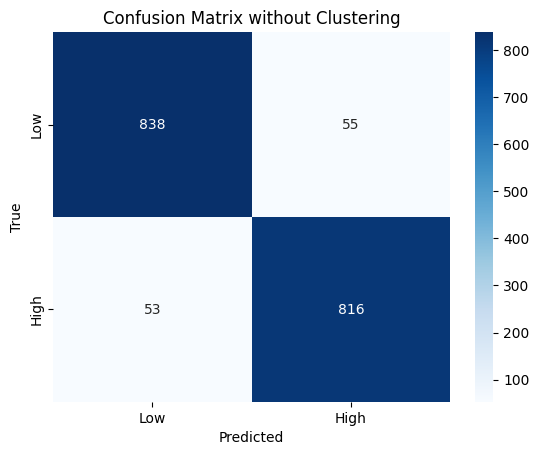

Accuracy with clustering: 0.9500567536889898
Accuracy without clustering: 0.9387060158910329


In [34]:
y_pred = model.predict(X_test)

print("Accuracy with clustering: ", accuracy_score(y_test, y_pred))
print("Classification Report with clustering: \n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Low", "High"], yticklabels=["Low", "High"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix with Clustering')
plt.show()

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("Best Hyperparameters: ", grid_search.best_params_)

best_rf_model = grid_search.best_estimator_
y_pred_best = best_rf_model.predict(X_test)
print("Accuracy with optimized hyperparameters: ", accuracy_score(y_test, y_pred_best))
print("Classification Report with optimized hyperparameters: \n", classification_report(y_test, y_pred_best))

cm_best = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm_best, annot=True, fmt="d", cmap="Blues", xticklabels=["Low", "High"], yticklabels=["Low", "High"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix with Optimized Hyperparameters')
plt.show()

X_no_cluster = df[['duration_scaled', 'release_year']]

X_train_no_cluster, X_test_no_cluster, y_train_no_cluster, y_test_no_cluster = train_test_split(X_no_cluster, y, test_size=0.2, random_state=42)

model_no_cluster = RandomForestClassifier(n_estimators=100, random_state=42)
model_no_cluster.fit(X_train_no_cluster, y_train_no_cluster)

y_pred_no_cluster = model_no_cluster.predict(X_test_no_cluster)

print("Accuracy without clustering: ", accuracy_score(y_test_no_cluster, y_pred_no_cluster))
print("Classification Report without clustering: \n", classification_report(y_test_no_cluster, y_pred_no_cluster))

cm_no_cluster = confusion_matrix(y_test_no_cluster, y_pred_no_cluster)
sns.heatmap(cm_no_cluster, annot=True, fmt="d", cmap="Blues", xticklabels=["Low", "High"], yticklabels=["Low", "High"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix without Clustering')
plt.show()

accuracy_with_clustering = accuracy_score(y_test, y_pred)
accuracy_without_clustering = accuracy_score(y_test_no_cluster, y_pred_no_cluster)

print(f"Accuracy with clustering: {accuracy_with_clustering}")
print(f"Accuracy without clustering: {accuracy_without_clustering}")